<a href="https://colab.research.google.com/github/vferman2000/Springboard/blob/master/ModelOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion Image Classification Project

The objective of the project is to build a Convolutional Neural Network model to classify fashion product images using TensorFow and Keras functional API.  The model will then predict the class of a given input image.

The dataset can be downloaded from https://www.kaggle.com/paramaggarwal/fashion-product-images-dataset

The platform selected for the project is Google Collab.

Different optimization techniques will be used to yield a classification system that is robust enough to address the needs of businesses requiring  a product catalog to classify items in an efficient and automated manner.





In [ ]:
# Install TensorFlow
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# importing additional libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import os

# Mounting to Google Drive

In [ ]:
# Path to fashion product images files on Google Drive

DATASET_PATH = "/content/drive/My Drive/Springboard Data Science/CapstoneTwo/fashion-product-images-small/myntradataset/"
print(os.listdir(DATASET_PATH))

['images', 'styles.csv']


In [ ]:
# Reading df_style pandas dataframe which contains images attributes
# Some rows have an extra column in their productDisplayName which will be ommitted.

df_styles = pd.read_csv(DATASET_PATH + 'styles.csv', usecols = lambda column : column not in range(11))

df_styles['image'] = df_styles.apply(lambda row: str(row['id']) + ".jpg", axis=1)

df_styles['masterCategory'] = df_styles.masterCategory.apply(lambda row: 'NA' if row is np.nan else row)

There are 7 distinct product categories in the dataset.  As shown below, the categories are unevenly distributed.  The data will need to be stratified for balance.

In [ ]:
df_styles.masterCategory.value_counts()

Apparel           21400
Accessories       11289
Footwear           9222
Personal Care      2404
Free Items          105
Sporting Goods       25
Home                  1
Name: masterCategory, dtype: int64

In [ ]:
# There is only one sample in the Home category.  It will be omitted.
df_styles_labels = df_styles[df_styles.masterCategory != 'Home']

Splitting dataset into train, validation and test subsets where each subset is stratisfied by the values in the masterCategory column of df_styles dataframe


In [ ]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.60, frac_val=0.20, frac_test=0.20,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_styles.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_validation, df_test, y_validation, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_validation) + len(df_test)

    return df_train, df_validation, df_test

In [ ]:
df_train, df_validation, df_test = \
    split_stratified_into_train_val_test(df_styles_labels, stratify_colname='masterCategory', frac_train=0.60, frac_val=0.20, frac_test=0.20)

In [ ]:
y_test = df_test.masterCategory
df_test_subset, df_control_subset, y_test_subset, y_control_subset = train_test_split(df_test, y_test, test_size=.50, stratify=y_test)

In [ ]:
print('The train subset has', len(df_train),'samples')
print('The validation subset has', len(df_validation),'samples')
print('The test subset has', len(df_test_subset),'samples')
print('The control subset has', len(df_control_subset),'samples')

The train subset has 26667 samples
The validation subset has 8889 samples
The test subset has 4444 samples
The control subset has 4445 samples


There are six unique categories in the masterCategory column that will be used as classes in the model.

In [ ]:
df_train.masterCategory.value_counts()

Apparel           12840
Accessories        6773
Footwear           5533
Personal Care      1443
Free Items           63
Sporting Goods       15
Name: masterCategory, dtype: int64

In [ ]:
# number of classes in masterCategory column of df_train
K = len(set(df_train.iloc[:,2]))
print('The number of classes is', K)

The number of classes is 6


In [ ]:
# Path to images folder
images_data = DATASET_PATH+"images/"

# Building the Convolutional Neural Network Model

The input image is 80x60 in size with an RGB channel. We will build a CNN model with a convolution + pooling architecture, followed by a number of fully connected Dense layers. 

The activation function for the convolutional layers will be ReLU ((Rectified Linear Units). 

The output layer will utilize a softmax activation function for the multiclass classification.

The hyperparameters that will be used are:
MaxPooling2d(2, 2) which extracts certain features from the image and reduces its height and the width. By using 2 pooling layers, the height and width are 1/4 of the original sizes.

BatchNormalization which regularizes and makes the training of convolutional neural networks more efficient.

Dropout to avoid overfitting



In [ ]:
# Build the convolutional Neural Network model using the functional API

# Input node. image shape: 80 x 60 x 3 RGB channels
i= Input(shape=(80, 60, 3))


# 2D convolutional layer with 2 spatial dimensions (height and width)
# Using more filters results in a more powerful model, but we risk overfitting due to increased parameter count.
# 32 initial output feature maps that will progressively increase with network depth. (Starts low to check for overfitting)
# A 3D filter with 3x3x3 dimensions
# A ReLU activation funcion

x = Conv2D(32, (3, 3), activation='relu', padding='valid')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)

# Pooling layer to reduce dimensionality (max pooling takes the maximum value in the pooling window)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Second convolutinal layer with increased number of feature maps
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Third convolutinal layer with increased number of feature maps
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

# Converting layer to 1 dimensional layer
x = Flatten()(x)
x = Dropout(0.2)(x)

# Fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# Fully connected layer with Softmax activation function for multiclass classification probability
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

# Mapping images to MasterCategory classes in df_styles using ImageDataGenerator

In [ ]:
# Using ImageDataGenerator to correlate images from image folder to masterCategory column in df_train, df_validation and df_test 

from keras.preprocessing.image import ImageDataGenerator
HEIGHT = 80
WIDTH = 60
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
                    dataframe=df_train,
                    directory=images_data,
                    x_col="image",
                    y_col="masterCategory",
                    batch_size=batch_size,
                    seed=42,
                    shuffle=True,
                    class_mode="categorical",
                    classes=['Footwear', 'Apparel', 'Accessories', 'Personal Care','Free Items','Sporting Goods'],
                    target_size=(HEIGHT,WIDTH))

valid_generator=test_datagen.flow_from_dataframe(
                    dataframe=df_validation,
                    directory=images_data,
                    x_col="image",
                    y_col="masterCategory",
                    batch_size=batch_size,
                    seed=42,
                    shuffle=True,
                    class_mode="categorical",
                    classes=['Footwear', 'Apparel', 'Accessories', 'Personal Care', 'Free Items','Sporting Goods'],
                    target_size=(HEIGHT,WIDTH))

test_generator=test_datagen.flow_from_dataframe(
                    dataframe=df_test_subset,
                    directory=images_data,
                    x_col="image",
                    batch_size=1,
                    seed=42,
                    shuffle=False,
                    class_mode=None,
                    target_size=(HEIGHT,WIDTH))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 4 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 26663 validated image filenames belonging to 6 classes.
Found 8889 validated image filenames belonging to 6 classes.
Found 4443 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# Compiling and Fitting the Model

1) Model compiled with:

*   Adam optimizer
*   learning rate of 0.001
*   Categorical crossentropy
*   Accuracy as the metric value



In [ ]:
# Compiling the model
# default value lr = 0.001 for adam optimizer

model.compile(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [ ]:
# Fitting the model
model_output_1 = model.fit(train_generator, validation_data=valid_generator, steps_per_epoch=int(train_generator.samples)/ batch_size, epochs=50)

Epoch 1/50
834/833 [==============================] - 152s 182ms/step - loss: 0.0094 - accuracy: 0.9977 - val_loss: 0.1558 - val_accuracy: 0.9862
Epoch 2/50
834/833 [==============================] - 153s 183ms/step - loss: 0.0079 - accuracy: 0.9981 - val_loss: 0.1252 - val_accuracy: 0.9874
Epoch 3/50
834/833 [==============================] - 151s 181ms/step - loss: 0.0070 - accuracy: 0.9977 - val_loss: 0.1963 - val_accuracy: 0.9839
Epoch 4/50
834/833 [==============================] - 151s 182ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.2073 - val_accuracy: 0.9691
Epoch 5/50
834/833 [==============================] - 154s 185ms/step - loss: 0.0097 - accuracy: 0.9973 - val_loss: 0.1539 - val_accuracy: 0.9865
Epoch 6/50
834/833 [==============================] - 152s 182ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.1834 - val_accuracy: 0.9766
Epoch 7/50
834/833 [==============================] - 154s 184ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.1684 -

2) Model compiled with:

*  Adam optimizer
*  Exponential Decay optimization with an initial learning rate of 0.001
*  Categorical crossentropy
*  Accuracy as the metric value






In [ ]:
# Compiling the model
# Exponential Decay with an initial learning rate of 0.001

lr_schedule = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_output_1 = model.fit(train_generator, validation_data=valid_generator, steps_per_epoch=int(train_generator.samples)/ batch_size, epochs=50, callbacks=[callback])

Epoch 1/50
834/833 [==============================] - 3778s 5s/step - loss: 0.1318 - accuracy: 0.9713 - val_loss: 0.0790 - val_accuracy: 0.9823
Epoch 2/50
834/833 [==============================] - 163s 195ms/step - loss: 0.0910 - accuracy: 0.9785 - val_loss: 0.0750 - val_accuracy: 0.9856
Epoch 3/50
834/833 [==============================] - 162s 195ms/step - loss: 0.0776 - accuracy: 0.9832 - val_loss: 0.0682 - val_accuracy: 0.9873
Epoch 4/50
834/833 [==============================] - 164s 196ms/step - loss: 0.0699 - accuracy: 0.9838 - val_loss: 0.0642 - val_accuracy: 0.9880
Epoch 5/50
834/833 [==============================] - 161s 194ms/step - loss: 0.0612 - accuracy: 0.9851 - val_loss: 0.0636 - val_accuracy: 0.9886
Epoch 6/50
834/833 [==============================] - 162s 195ms/step - loss: 0.0540 - accuracy: 0.9854 - val_loss: 0.0593 - val_accuracy: 0.9888
Epoch 7/50
834/833 [==============================] - 161s 193ms/step - loss: 0.0546 - accuracy: 0.9868 - val_loss: 0.0573 - v

In [ ]:
# This the first model chosesn as first model to be used in an ensemble model due to its high accuracy of 0.9915

model.save('/content/drive/My Drive/Springboard Data Science/CapstoneTwo/model_3.h5')


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 60, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 78, 58, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 78, 58, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 56, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 76, 56, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 38, 28, 32)        0     

In [ ]:
score_1 = model.evaluate(valid_generator)
print('Test loss:', score_1[0])
print('Test accuracy:', score_1[1])

278/278 [==============================] - 39s 142ms/step - loss: 0.0668 - accuracy: 0.9915
Test loss: 0.06681511551141739
Test accuracy: 0.9914501309394836


# Model Evaluation

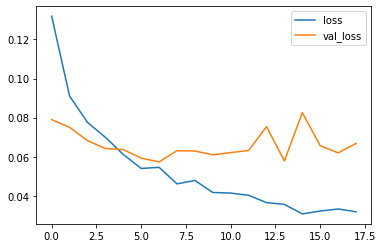

In [ ]:
# Plot loss per iteration
plt.plot(model_output_1.history['loss'], label='loss')
plt.plot(model_output_1.history['val_loss'], label='val_loss')
plt.legend()

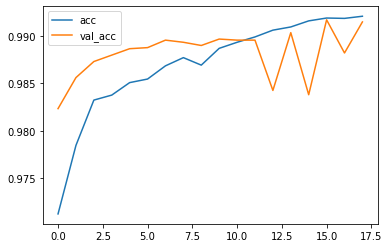

In [ ]:
# Plot accuracy per iteration
plt.plot(model_output_1.history['accuracy'], label='acc')
plt.plot(model_output_1.history['val_accuracy'], label='val_acc')
plt.legend()

# Confusion Matrix

278/278 [==============================] - 39s 142ms/step
Confusion matrix, without normalization
[[ 594 1084  485    0   95    0]
 [1086 2086  875    0  229    4]
 [ 468  872  374    0  129    1]
 [   9    6    6    0    0    0]
 [ 115  244  100    0   22    0]
 [   0    1    4    0    0    0]]


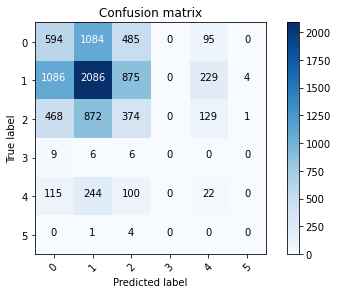

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

valid_generator.reset()
valid_steps_per_epoch = np.math.ceil(valid_generator.samples / valid_generator.batch_size)
p_test=model.predict(valid_generator,verbose=1,steps=valid_steps_per_epoch).argmax(axis=1)

cm = confusion_matrix(valid_generator.classes, p_test)
plot_confusion_matrix(cm, list(range(6)))




# Model # 2

In [ ]:
# Build the convolutional Neural Network model using the functional API

# Input node. image shape: 80 x 60 x 3 RGB channels
i= Input(shape=(80, 60, 3))


# 2D convolutional layer with 2 spatial dimensions (height and width)
# Using more filters results in a more powerful model, but we risk overfitting due to increased parameter count.
# 32 initial output feature maps that will progressively increase with network depth. (Starts low to check for overfitting)
# A 3D filter with 3x3x3 dimensions
# A ReLU activation funcion

x = Conv2D(32, (3, 3), activation='relu', padding='valid')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)

# Pooling layer to reduce dimensionality (max pooling takes the maximum value in the pooling window)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Second convolutinal layer with increased number of feature maps
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Third convolutinal layer with increased number of feature maps
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

# Converting layer to 1 dimensional layer
x = Flatten()(x)
x = Dropout(0.2)(x)

# Fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# Fully connected layer with Softmax activation function for multiclass classification probability
x = Dense(K, activation='softmax')(x)

model_2 = Model(i, x)

3) Model compiled with:

*  Stochastic Gradient Descent (SGD) optimizer
*  Exponential Decay optimization with an initial learning rate of 0.01
*  Categorical crossentropy
*  Accuracy as the metric value


In [ ]:
# Compiling the model
#Exponential Decay with an initial learning rate of 0.01

lr_schedule = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.optimizers.SGD(learning_rate=lr_schedule)

model_2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_output_2 = model_2.fit(train_generator, validation_data=valid_generator, 
                         steps_per_epoch=int(train_generator.samples)/ batch_size, epochs=50, callbacks=[callback] )

Epoch 1/50
834/833 [==============================] - 160s 192ms/step - loss: 0.3280 - accuracy: 0.9059 - val_loss: 0.1416 - val_accuracy: 0.9589
Epoch 2/50
834/833 [==============================] - 159s 191ms/step - loss: 0.1464 - accuracy: 0.9545 - val_loss: 0.1379 - val_accuracy: 0.9568
Epoch 3/50
834/833 [==============================] - 159s 190ms/step - loss: 0.1146 - accuracy: 0.9660 - val_loss: 0.0966 - val_accuracy: 0.9704
Epoch 4/50
834/833 [==============================] - 158s 190ms/step - loss: 0.0950 - accuracy: 0.9736 - val_loss: 0.1453 - val_accuracy: 0.9532
Epoch 5/50
834/833 [==============================] - 160s 191ms/step - loss: 0.0823 - accuracy: 0.9760 - val_loss: 0.0987 - val_accuracy: 0.9718
Epoch 6/50
834/833 [==============================] - 160s 191ms/step - loss: 0.0762 - accuracy: 0.9788 - val_loss: 0.0786 - val_accuracy: 0.9772
Epoch 7/50
834/833 [==============================] - 160s 192ms/step - loss: 0.0692 - accuracy: 0.9805 - val_loss: 0.2475 -

In [ ]:
# This the second model chosesn as first model to be used in an ensemble model due to its high accuracy of 0.9877

model_2.save('/content/drive/My Drive/Springboard Data Science/CapstoneTwo/model_4.h5')


In [ ]:
score_2 = model_2.evaluate(valid_generator)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

278/278 [==============================] - 39s 141ms/step - loss: 0.0544 - accuracy: 0.9877
Test loss: 0.054395657032728195
Test accuracy: 0.9877376556396484


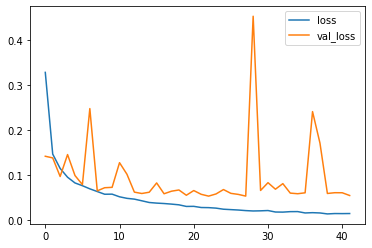

In [ ]:
# Plot loss per iteration
plt.plot(model_output_2.history['loss'], label='loss')
plt.plot(model_output_2.history['val_loss'], label='val_loss')
plt.legend()


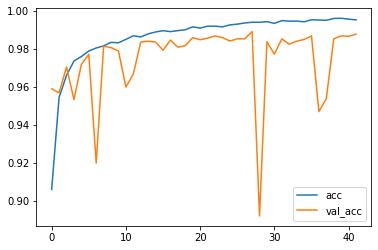

In [ ]:
# Plot accuracy per iteration
plt.plot(model_output_2.history['accuracy'], label='acc')
plt.plot(model_output_2.history['val_accuracy'], label='val_acc')
plt.legend()

278/278 [==============================] - 39s 142ms/step
Confusion matrix, without normalization
[[ 641 1045  449    2  121    0]
 [1026 2129  896    3  226    0]
 [ 446  889  406    2  101    0]
 [   5    7    5    0    4    0]
 [ 132  230   91    0   28    0]
 [   1    4    0    0    0    0]]


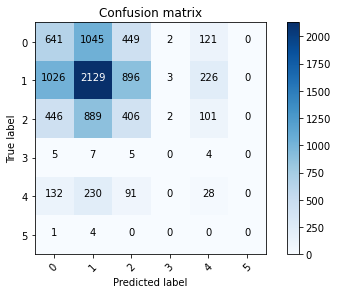

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

valid_generator.reset()
valid_steps_per_epoch = np.math.ceil(valid_generator.samples / valid_generator.batch_size)
p_test=model_2.predict(valid_generator,verbose=1,steps=valid_steps_per_epoch).argmax(axis=1)

cm = confusion_matrix(valid_generator.classes, p_test)
plot_confusion_matrix(cm, list(range(6)))

# Parameter averaging across models using selected models

In [ ]:
from keras.models import load_model
models=[]

model1=tf.keras.models.load_model('/content/drive/My Drive/Springboard Data Science/CapstoneTwo/model_3.h5') # load model
model2=tf.keras.models.load_model('/content/drive/My Drive/Springboard Data Science/CapstoneTwo/model_4.h5') # load model


models.append(model1)
models.append(model2)

In [ ]:
print(models)

[<tensorflow.python.keras.engine.training.Model object at 0x7fc8b87d9438>, <tensorflow.python.keras.engine.training.Model object at 0x7fc8b7a16d30>]


In [ ]:
def ensembleModels(models, model_input):
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models] 
    # averaging outputs
    yAvg=layers.average(yModels) 
    # build model from same input and avg output
    modelEns = Model(inputs=model_input, outputs=yAvg, name='ensemble')  
   
    return modelEns

In [ ]:
model_input = Input(shape=(80,60,3))
modelEns = ensembleModels(models, model_input)
model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 80, 60, 3)]       0         
_________________________________________________________________
dense_20 (Dense)             (None, 80, 60, 1)         4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras import layers
def get_model():
    inputs = keras.Input(shape=(80,60,3))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()

inputs = tf.keras.Input(shape=(80,60,3))
y1 = model1(inputs)
y2 = model2(inputs)


outputs = layers.average([y1, y2])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:


lr_schedule = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)

modelEns.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_output_3=modelEns.fit(train_generator, validation_data=valid_generator, steps_per_epoch=int(train_generator.samples)/ batch_size, epochs=50, callbacks=[callback])

Epoch 1/50
834/833 [==============================] - 165s 198ms/step - loss: 0.0907 - accuracy: 0.9284 - val_loss: 0.1034 - val_accuracy: 0.9277
Epoch 2/50
834/833 [==============================] - 163s 196ms/step - loss: 0.0879 - accuracy: 0.9292 - val_loss: 0.0962 - val_accuracy: 0.9325
Epoch 3/50
834/833 [==============================] - 164s 197ms/step - loss: 0.0827 - accuracy: 0.9304 - val_loss: 0.0969 - val_accuracy: 0.9336
Epoch 4/50
834/833 [==============================] - 164s 196ms/step - loss: 0.0789 - accuracy: 0.9335 - val_loss: 0.0912 - val_accuracy: 0.9376
Epoch 5/50
834/833 [==============================] - 165s 197ms/step - loss: 0.0764 - accuracy: 0.9332 - val_loss: 0.0930 - val_accuracy: 0.9271
Epoch 6/50
834/833 [==============================] - 164s 196ms/step - loss: 0.0782 - accuracy: 0.9321 - val_loss: 0.1828 - val_accuracy: 0.8464
Epoch 7/50
834/833 [==============================] - 165s 198ms/step - loss: 0.0735 - accuracy: 0.9352 - val_loss: 0.1038 -

In [ ]:
# saving the model
model3.save('/content/drive/My Drive/Springboard Data Science/CapstoneTwo/model_5.h5')

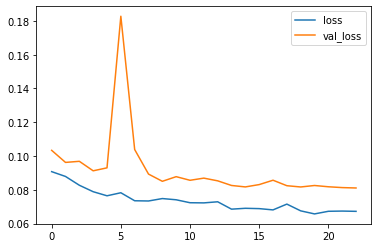

In [ ]:
# Plot loss per iteration
plt.plot(model_output_3.history['loss'], label='loss')
plt.plot(model_output_3.history['val_loss'], label='val_loss')
plt.legend()


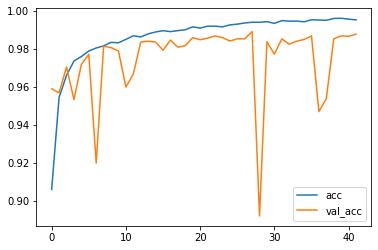

In [ ]:
# Plot accuracy per iteration
plt.plot(model_output_2.history['accuracy'], label='acc')
plt.plot(model_output_2.history['val_accuracy'], label='val_acc')
plt.legend()